
# Applications of DeepChem with Alphafold: Docking and protein-ligand interaction from protein sequence

Author: Sriphani Vardhan Bellamkonda


In this tutorial, we explore a potential use case where we combine the capabilities of AlphaFold and DeepChem.

Alphafold2 has made immense strides in predicting protein structure folding without the use of costly lab equipment and DeepChem comprises a repertoire of easy to use modules which can then be applied on these protein structures for further analysis. In the first part of our tutorial we will predict the protein structure when given a protein sequence. Then, in the second part of our tutorial, we sample a few ligands from the protein-complex dataset(PDBbind) and perform programmatic docking to estimate binding affinities between our protein and a number of ligands.

This tutorial is meant to be run in google colab. You can follow the below link to open this notebook in colab.

<a target="_blank" href="https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/DeepChemXAlphafold.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Setup

*We start off with all the installations and configurations. If you would like to directly skip reading this part, you can head over to the [Input Query Section](#input-query) below.*

We will first be installing deepchem as a runtime restart might be required.
Along with that lets also install condacolab, vina and pdbfixer which will be used in the later parts of this tutorial.

In [1]:
from google.colab import drive
import os

# Mount Google Drive to the standard location
drive.mount('/content/drive', force_remount=True)

# Specify your output directory in your Google Drive
output_dir = '/content/drive/MyDrive/drug_discovery_datasets/'  # Adjust the path as needed based on your Google Drive structure

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


Mounted at /content/drive


In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge openmm -y
!mkdir vina_test

!conda install -c conda-forge pdbfixer
!conda install -c conda-forge vina
!pip install deepchem
!pip install -q mdtraj nglview

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

mkdir: cannot create directory ‘vina_test’: File exists
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# A

**Restart may be prompted**

### Part 1: Predict Protein Structure in pdb format from a given input sequence

Note: The cells until part 2 of this tutorial are directly from the Colabfold's google colab implementation and have been further annotated in this tutorial.

## Alphafold Colabfold Openfold .....so many folds!

In 2020, a major breakthrough in protein structure prediction occurred when AlphaFold2, a newer version of AlphaFold, vastly outperformed other models in the CASP (Critical Assessment of Protein Structure Prediction) competition. After this breakthrough event, several organizations worked ahead of AlphaFold2 and provided slightly different solutions for the protein folding problem. For example, ColabFold provides faster protein structure modeling because it uses a separate server for the sequence alignment step of AlphaFold2, and OpenFold provides a few enhancements, such as faster inference and custom CUDA attention kernels, while being implemented in PyTorch. Apart from these, there are other protein folding models, such as AlphaFold-multimer, OmegaFold, and RosettaFold, designed for different scenarios. Due to its simplicity, we will be using Colabfold in our tutorial.

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:140px">

## ColabFold v1.5.3-patch: AlphaFold2 using MMseqs2

ColabFold is an easy to use protien structure and complex prediction model which uses Alphafold2 and Alphafold2-multimer for sequence to structure prediction of single and multiple protein chains. It also abstracts out the Sequence Alignment/Template Generation step or MSA, Multiple Sequence Alignemnt, through MMSeqs2 and HHsearch. MSA step is explained in more detail in the cells below.

 For more details, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read the below manuscript.

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)


We then create a job-name folder and store all the sequences as queries in a text file which we will reference later to call model inference on. The way that Alphafold is structured is that it interacts with a job directory to process the inputs, templates, and save the outpus. Hence, it is important to create a unique job folder.

In [3]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

# query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
query_sequence='#'
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber

use_amber = num_relax > 0

Use the below parameter to set template configs.

AlphaFold uses templates from a vast protein structure database to guide its predictions. It aligns the target protein's sequence with similar sequences from the database to generate structural constraints, aiding in the accurate prediction of the protein's 3D structure.

`none` = no template information is used. In this case the sequence alignment step is skipped and prediction is made without it.

`pdb100` = templates are detected from the pdb100 database. pdb100 is a subset of the Protein Data Bank (PDB) containing 100 diverse protein structures used for training and validation in structural biology and bioinformatics research.

 `custom` = the user has the option to upload their own templates database to search on (PDB or mmCIF format)


In [4]:
template_mode = "none" #@param ["none", "pdb100","custom"]

Lets specify a hashing function which we will use to create a job name. Hashing is mainly used to reduce the length of the folder name in order to have reasonable and unique jobname everytime we run the notebook.

In [5]:
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

We then create the directory where we will store our protein seqeunce (query) and respective files which will be generated in the later parts of this tutorial. We also define a check function below which prevents us from creating duplicate directories.

In [6]:
# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

Based on the template_mode specified earlier, we automatically adjust a few parameters such as use_templates and custom_template_path. If the template_mode is custom, we will create an additional directory for it.

In [7]:
if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

### Install dependencies

Based on the parameters mentioned above we will respectively install the dependencies with the code below.

1. First we have to install the latest version of ColabFold from their github repo. After a successful installation, a file called COLABFOLD_READY will be created to mark its completion.

In [8]:
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

installing colabfold...
CPU times: user 290 ms, sys: 44 ms, total: 334 ms
Wall time: 1min 9s


2. Next, if we need amber relaxation or protein templates, we will install mamba which will help us in installing further packages


In [9]:
if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

3. Then, we will install hhsuite for db-search/tempate-retireval and openmm for amber relaxation.


In [10]:
if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

A little about the softwares we are installing:

**HHsuite** is a widely used open source software suite for sensitive sequence similarity searches and protein fold recognition.

**Openmm** is a high-performance toolkit for molecular simulation. In our tutorial this tooklkit helps us simulate amber force field which is used to "relax" the position of atoms with respect to each other in order to remove any definite obstructions between them. This helps us to better model protein folding in edge cases and offers better refinement of the protein structures.

Now lets specifiy the different msa options available.

## MSA
Multi Sequence Alignment is a process in Alphafold which aligns multiple sequences of amino acids from different sources which have a similar sequence. In this step, Alphafold2 forms a grid aligning identical amino acids in the same columns and leaving gaps where there are differences. We have the option of how we would like to pair the respective MSA with the options: "unpaired_paired" to pair sequences from same species and an unpaired MSA, "unpaired" to seperate MSA for each chain, and "paired" to only use paired sequences. Additionally, we have multiple options in the way Alphafold searches for the respective sequences and few of them are mentioned below.

**MMSEQ2**: This is a sequence searching tool which finds similar sequences to our input sequence from a large database.

**Single_sequence**: This option restricts Alphafold from searching for any similar amino acid sequences and restricts it utilize the only given one.

**Custom**: This options lets Alphafold do the sequence search from user defined sequence search space.

In [11]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "single_sequence" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

So based on the above msa parameters we will set the path to the A3M file. An A3M file (Alignment to Multiple Models) is a type of input file used in the protein structure prediction process which contains multiple sequence alignments (MSAs) of related protein sequences that are used as input data for the AlphaFold model.
A3M file format is an extentions to FASTA file format and can be read about over at [FASTA format extension](https://en.wikipedia.org/wiki/FASTA_format).

Additionally, for the purpose of this tutorial we don't need to get into the details of custom MSA(where user inputs their own template databse for search).

In [12]:
# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

# Advanced settings

Below we can specify more advanced settings with Alphafold. We can choose which model parameters to use from the options given below i.e alphafold2, alphafold2_multimer_v1 etc.., recycle early stop tolerence, saving to google drive, and image resolution options. Also note that there is no need to fully understand the parameters and just stick to the defaults. But here are a few details about the parameters which can be changed.  

**model_type**: If auto selected, will use alphafold2_ptm for monomer prediction and alphafold2_multimer_v3 for complex prediction. Any of the mode_types can be used (regardless if input is monomer or complex).

**num_recycles**: "auto" with other options available as ["auto", "0", "1", "3", "6", "12", "24", "48"]

**recycle_early_stop_tolerance**: "auto" with other options available as ["auto", "0.0", "0.5", "1.0"]

By "recycling" Alphafold refers to the process of iterative refinement of protein structure prediction to imporve accuracy.

**Pairing strategy**: "greedy" or "complete"

1. `greedy` = pair any taxonomically matching subsets
2. `complete` = all sequences have to match in one line.

<!-- Don't forget to hit `Runtime` -> `Run all` after updating the form. -->

In [13]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.

We can also set the maximum length of Multiple Sequence Alignment, Number of Seeds, and whether to use dropout or not.

**max_msa** = "auto" with other optinos as ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]. Here left is the minimum and right is the maximum msa length.

**num_seeds** = 1 with other options as [1,2,4,8,16] {type:"raw"}

**use_dropout** = False other option True

In [14]:
#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

### Save to Google Drive
We define a simple save_to_google_drive function which authenticates into our respective google drive and allows to save our files.

In [15]:
#@markdown #### Save settings
save_all = True #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = True #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

You are logged into Google Drive and are good to go!


Now we will run the prediction model using all the inputs and specifications from above.


We import the respective files from Colabfold's package for inference and plotting, and we then check if we have a specific GPU. We also define 2 helper functions: input_features_callback, and prediction_callback, which help us to visualize the respective input featues and prediction results.

Lets import utility, batch and plotting functions from colabfold!

In [16]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np


Next we check if K80 GPU is available.

In [17]:
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

#### Now, let's define some helper functions to visualize input features and output preduction.


In [18]:
from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

#### Let's define our logging environment and retrieve the input queries from our job folder.

In [19]:
result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

## <a name="input-query">Input Query Sequence</a>
Lets specify our input for Sequence to Structure prediction. We should specify the input sequence (seperated by ':' for specifying inter-protein chain breaks to model complexes) and whether we would like to use amber relaxation or not.

In [20]:
query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}

We then store our query_sequence in a csv inside the jobname director. This facilates multiple query execution and provides input in the format expected by ColabFold.

In [21]:
# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

We utilize the get_queries function, which is a colabfold utility function, to fetch the queries from the directory.

One downside to having a high number of sequence alignemts(~128) detected in the MSA step is that it is quadrateically expensive to continue the later steps in inference. In order, to reduce this the MSA's are clustered smartly, based on sequence similarity, in order to reduce the computational cost while ensuring that each MSA has some influence on the final prediction. This clustering step is captured by use_cluster_profile which is also configured below.


In [22]:
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

# Inference

Our final step is to download the alphafold parameters for the model and run inference using all the previous given specifications and inputs.

We will then save the results in a zip file and download it.

2024-05-04 22:12:17,543 WARNING: no GPU detected, will be using CPU
2024-05-04 22:12:21,568 Found 2 citations for tools or databases
2024-05-04 22:12:21,569 Query 1/1: test_d08f8 (length 59)


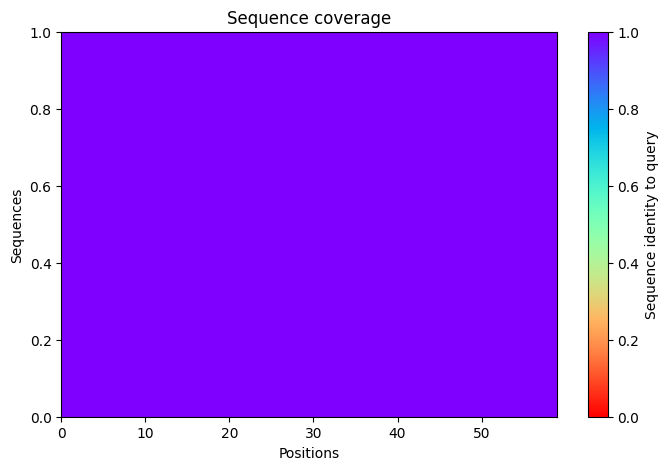

2024-05-04 22:13:37,152 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=56.9 pTM=0.375
2024-05-04 22:14:28,832 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=60.8 pTM=0.411 tol=1.55
2024-05-04 22:15:20,388 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=62.6 pTM=0.415 tol=0.695
2024-05-04 22:16:12,073 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=64.4 pTM=0.433 tol=0.281
2024-05-04 22:16:12,075 alphafold2_ptm_model_1_seed_000 took 221.8s (3 recycles)


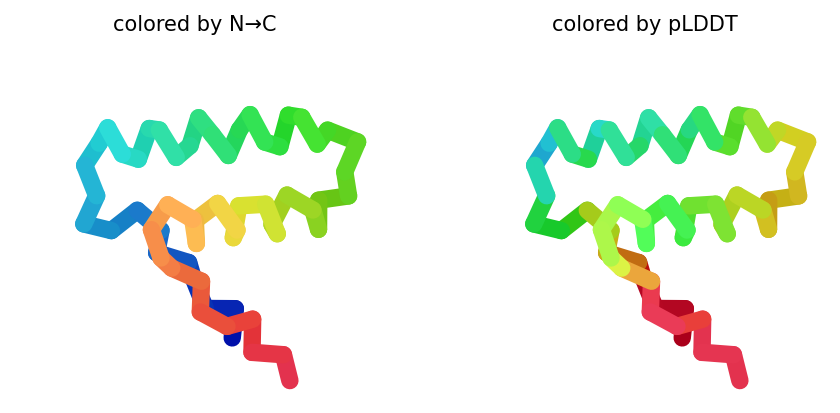

2024-05-04 22:17:04,663 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=52.3 pTM=0.375
2024-05-04 22:17:56,709 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=55.8 pTM=0.405 tol=1.66
2024-05-04 22:18:52,298 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=58.9 pTM=0.402 tol=0.658
2024-05-04 22:19:47,938 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=60.8 pTM=0.398 tol=0.748
2024-05-04 22:19:47,940 alphafold2_ptm_model_2_seed_000 took 215.7s (3 recycles)


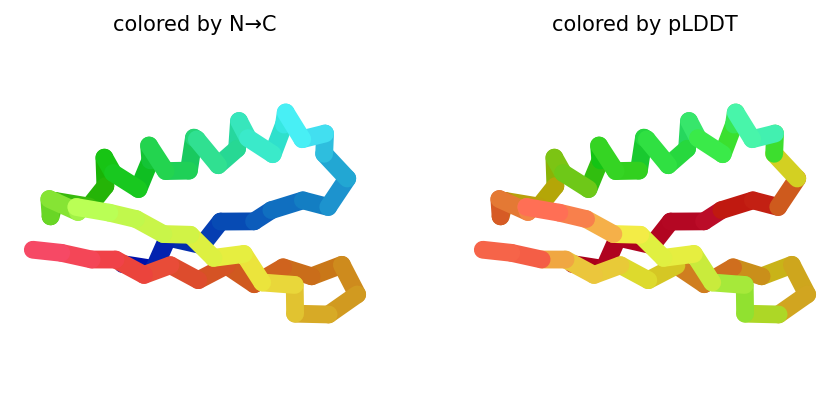

2024-05-04 22:20:42,947 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=57.5 pTM=0.398
2024-05-04 22:21:38,339 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=60.4 pTM=0.42 tol=3.58
2024-05-04 22:22:33,289 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=61 pTM=0.408 tol=2.36
2024-05-04 22:23:28,585 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=62.2 pTM=0.415 tol=0.296
2024-05-04 22:23:28,587 alphafold2_ptm_model_3_seed_000 took 220.5s (3 recycles)


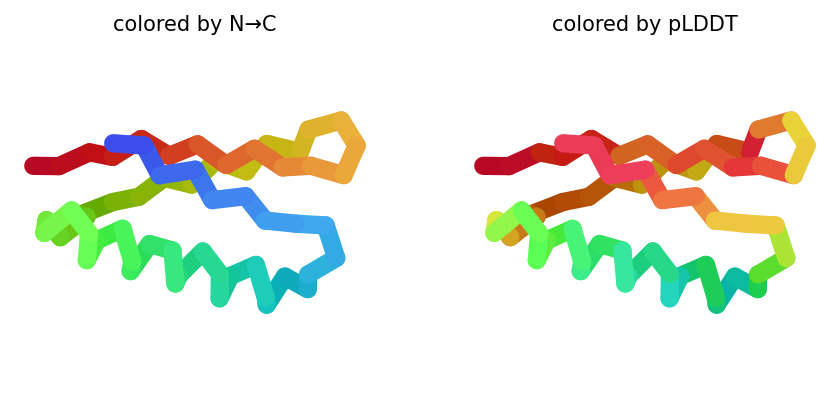

2024-05-04 22:24:23,725 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=53.5 pTM=0.382
2024-05-04 22:25:18,945 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=61.9 pTM=0.437 tol=3.01
2024-05-04 22:26:14,021 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=62.2 pTM=0.444 tol=0.945
2024-05-04 22:27:08,955 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=57.3 pTM=0.422 tol=1.71
2024-05-04 22:27:08,957 alphafold2_ptm_model_4_seed_000 took 220.2s (3 recycles)


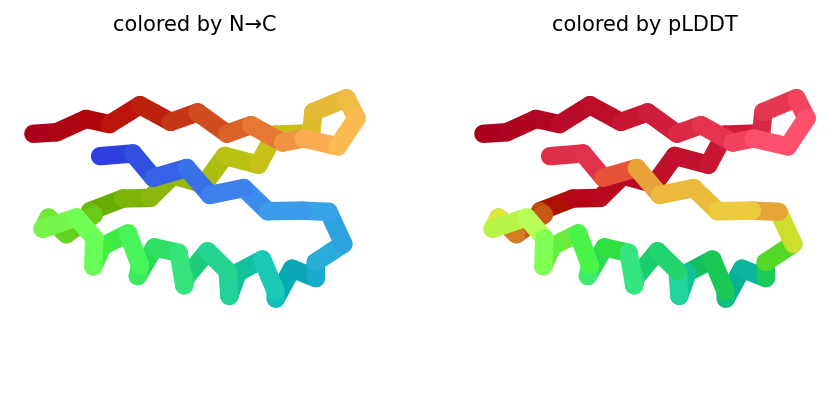

2024-05-04 22:28:04,475 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=54.5 pTM=0.334
2024-05-04 22:29:03,081 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=55.3 pTM=0.348 tol=2.74
2024-05-04 22:29:57,821 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=65.7 pTM=0.419 tol=2.94
2024-05-04 22:30:53,476 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=70.2 pTM=0.487 tol=1.12
2024-05-04 22:30:53,477 alphafold2_ptm_model_5_seed_000 took 224.3s (3 recycles)


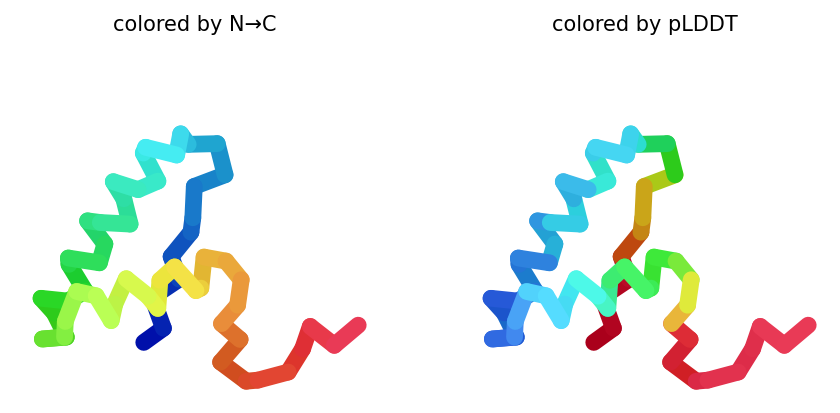

2024-05-04 22:30:53,605 reranking models by 'plddt' metric
2024-05-04 22:30:53,606 rank_001_alphafold2_ptm_model_5_seed_000 pLDDT=70.2 pTM=0.487
2024-05-04 22:30:53,606 rank_002_alphafold2_ptm_model_1_seed_000 pLDDT=64.4 pTM=0.433
2024-05-04 22:30:53,607 rank_003_alphafold2_ptm_model_3_seed_000 pLDDT=62.2 pTM=0.415
2024-05-04 22:30:53,608 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=60.8 pTM=0.398
2024-05-04 22:30:53,610 rank_005_alphafold2_ptm_model_4_seed_000 pLDDT=57.3 pTM=0.422
2024-05-04 22:30:54,875 Done


0

In [23]:
download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

### Display 3D structure of the protein file generated based on a few options and using py3Dmol package

Alphafold generates top n ranked model estimates of the protein structure.
Here we have 5 ranked structures. The lower the rank the higher the accuracy and quality of the predicted model.

Here we can display the structure with various color schemas: chair, lDDT, and rainbow.
We also have options to show the sidechain and mainchains of the protein's structure.

Let's import a few important visualization libraries and set the visualization variables.

In [24]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

### Capture the protein structure
Let us store the file path to the generated protein structure so that we can utilize it in the second part of our tutorial for pocket finding and protein-ligand interactions!

In [25]:
print("Files generated: ", pdb_filename, pdb_file)
pdb_filename_captured = pdb_filename

Files generated:  test_d08f8/test_d08f8_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb ['test_d08f8/test_d08f8_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb']


Now lets define the visualization function show_pdb using py3Dmol. This function takes in the pdb and various visualization parameters such as rank number, sidechains, and mainchains and visualizes the protein accordingly Here we have passed "lDDT" for the color parameter of the function. lDDT is in short for local Distance Difference Test. We display the color based on the score for each part of the protein as mentioned in the key of the .


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

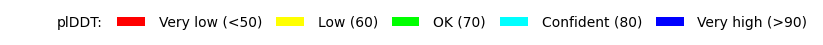

In [26]:
def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

## PLOTS of Alphafold

The following 3 types of plots are generated with Alphafold.

1. **PAE** (Predicted Average Error): It measures the average error in the predicted atomic positions of a protein's 3D structure compared to the true positions. In our experiment below, the PAE plot of the top 5 ranked sturctures is mostly blue which means that we have low errors.

2. **COV** (Sequence Coverage): It indicates the percentage of aminoacid sequence for which Alphafold has provided structural prediction and to what degree. In the plot below, the x-axis represents the amino acid sequence and the y-axis represents the number sequences for that amino acid.

3. **iDDT** (local Distance Difference Test) or lDDT: It provides a per-residue measure of the predicted model's confidence. It assigns a score to each residue in the protein structure, indicating the reliability of the prediction at that location. For our protein sequence the lDDT is high throughout the amino acid sequence but tends to get lower towards the right end.


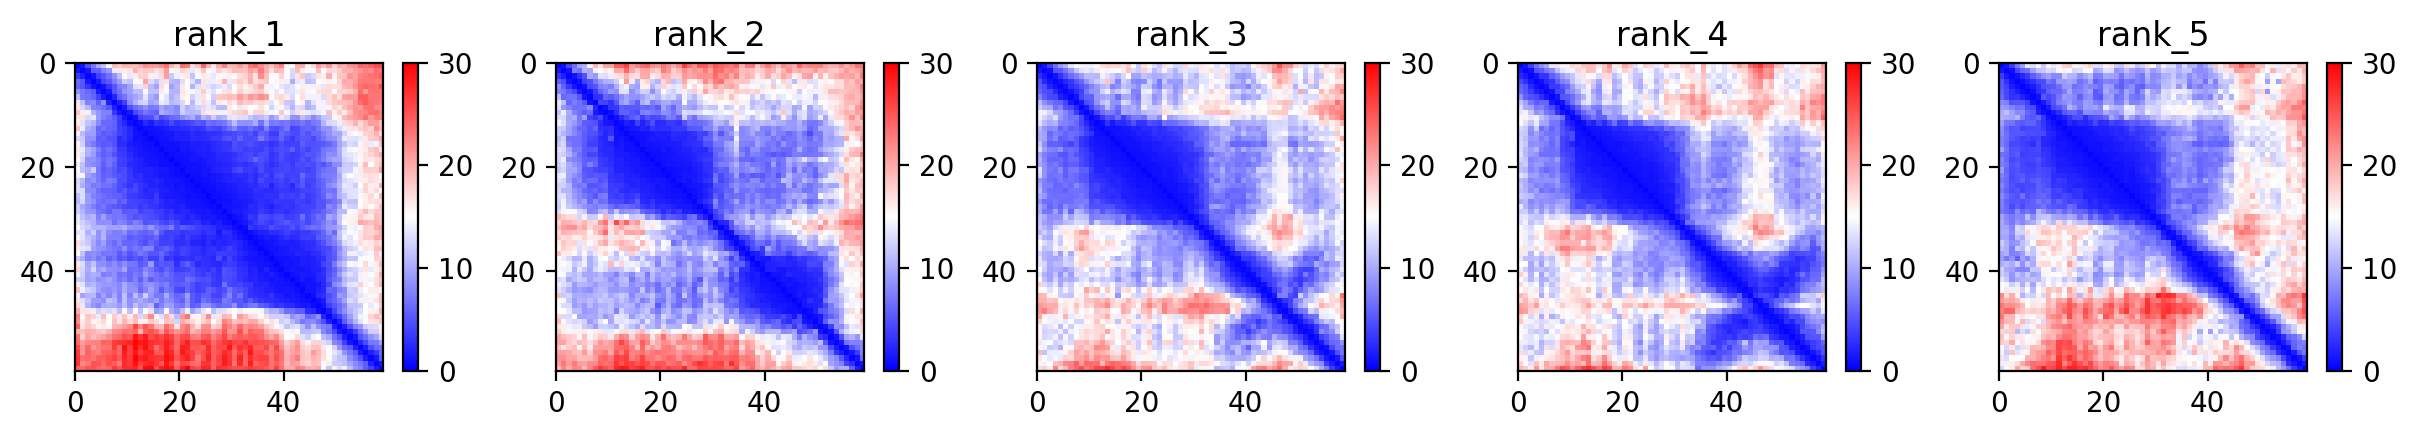
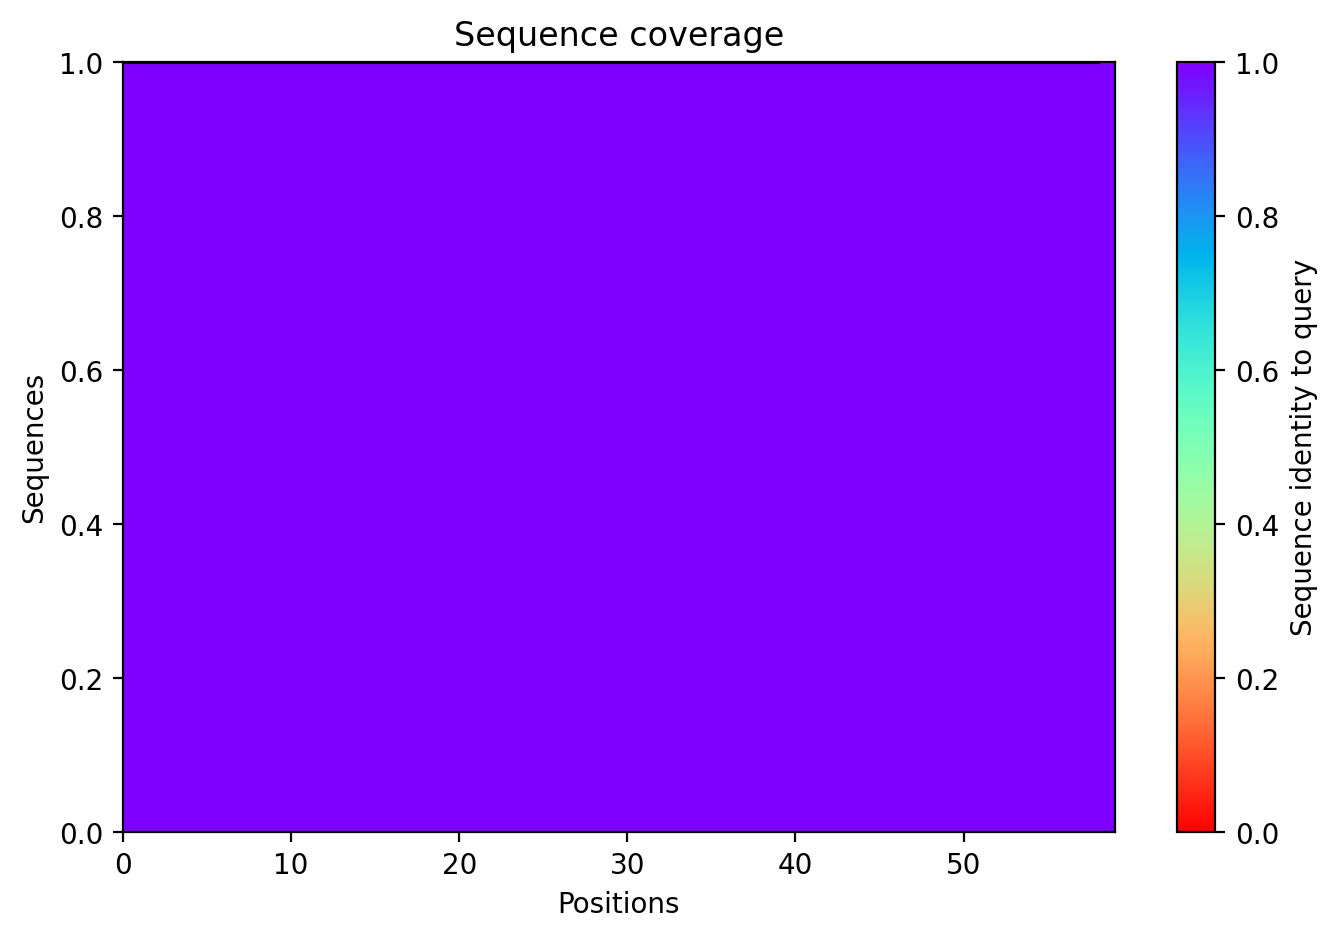
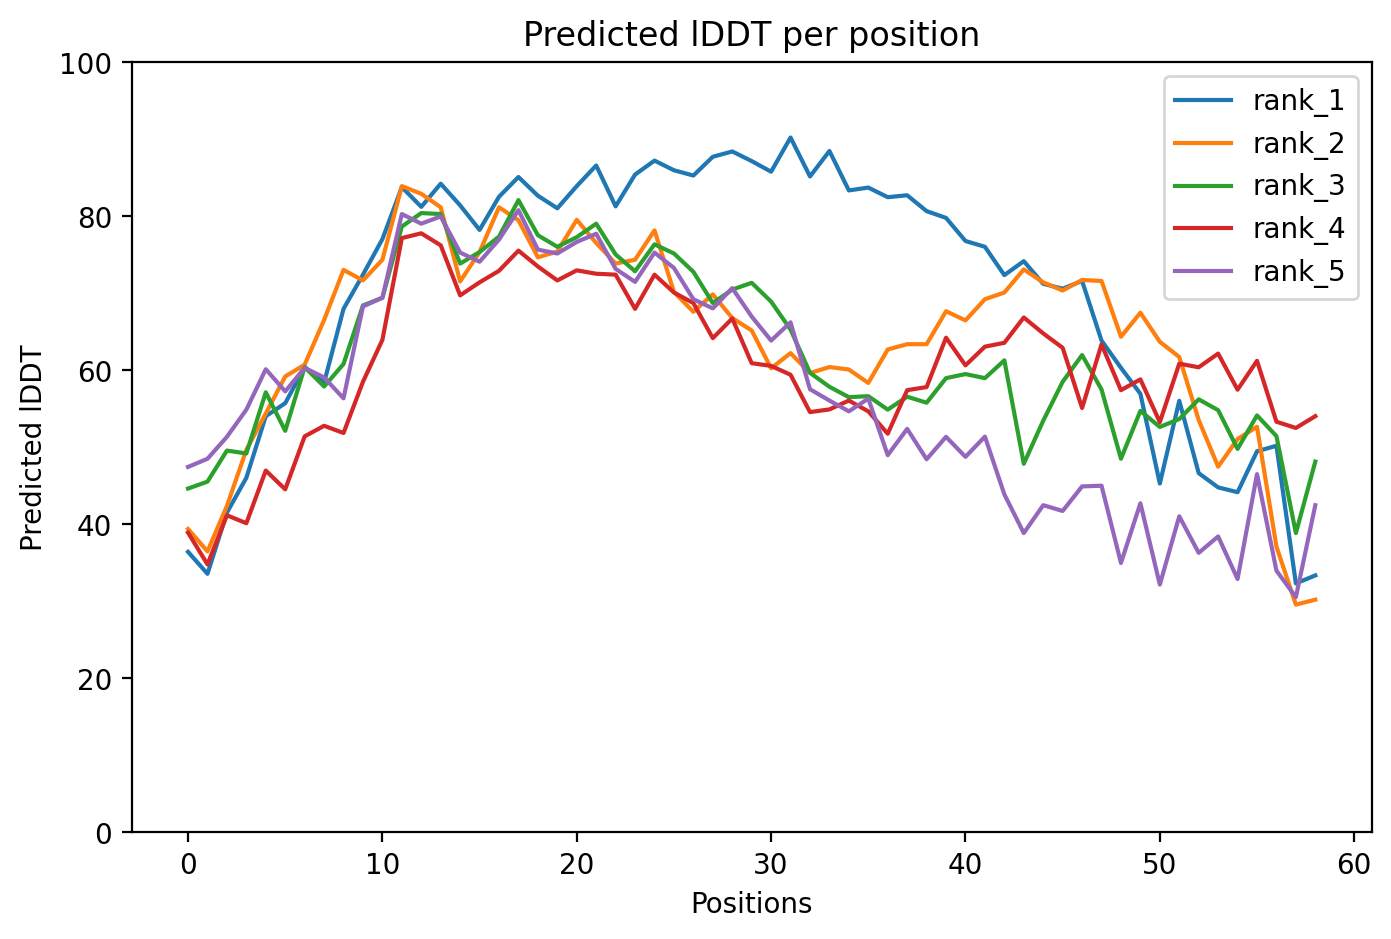

In [27]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

### Package and download results(optional)
The below code can be used to download the generated zip folder to your local system or saved to google drive.

In [28]:
if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2024-05-04 22:30:55,927 file_cache is only supported with oauth2client<4.0.0
Uploaded test_d08f8.result.zip to Google Drive with ID 1vS7Qij4Yyz9-RMP7FANuhtPByv1LiHDM


# Part 2: Estimate binding affinities between the predicted protein and a sample set of ligands


Let's import deepchem utility functions and rdkit which helps us in visualization.

In [29]:
import os
import numpy as np
import pandas as pd

import tempfile

from rdkit import Chem
from rdkit.Chem import AllChem

import deepchem as dc
from deepchem.utils import download_url, load_from_disk

2024-05-04 22:30:57,195 Enabling RDKit 2023.09.6 jupyter extensions
2024-05-04 22:31:03,476 No normalization for SPS. Feature removed!
2024-05-04 22:31:03,478 No normalization for AvgIpc. Feature removed!
2024-05-04 22:31:05,536 Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
2024-05-04 22:31:05,676 Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/usr/local/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
2024-05-04 22:31:05,678 Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'


To sample a set of ligands we will use [PDBind](http://www.pdbbind.org.cn/).
We will download the respective dataset file and store it in a variable called raw_dataset.

In [30]:
data_dir = dc.utils.get_data_dir()
dataset_file = os.path.join(data_dir, "pdbbind_core_df.csv.gz")

if not os.path.exists(dataset_file):
    print('File does not exist. Downloading file...')
    download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/pdbbind_core_df.csv.gz")
    print('File downloaded...')

raw_dataset = load_from_disk(dataset_file)
raw_dataset = raw_dataset[['pdb_id', 'smiles', 'label']]


from openmm.app import PDBFile
from pdbfixer import PDBFixer

from deepchem.utils.vina_utils import prepare_inputs

File does not exist. Downloading file...
File downloaded...


### Pocket finding in the predicted protein structure
By utilizing DeepChem's docking modules we can find the number of pockets in the generated structure. We do so by utilizing the 3D-ConvexHullPocketFinder.


In [31]:
ligands10 = raw_dataset['smiles'].iloc[0:10]

# %%time
import os
#'test_a5e17/test_a5e17_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb'
generated_pdb = pdb_filename_captured
generated_pdb_no_extension = os.path.splitext(os.path.basename(generated_pdb))[0]

finder = dc.dock.binding_pocket.ConvexHullPocketFinder()
pockets = finder.find_pockets(generated_pdb)

print("Pockets for protein: "  + str(len(pockets)) ) # number of identified pockets


2024-05-04 22:31:08,808 Mol CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@@H]1CCCNC2(=N)NC2C(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@@H]2CCCN2)[C@@H](C)CC)[C@@H](C)CC)[C@@H](C)CC)C(=O)N[C@@H](CCC(=O)O)C(=O)NCC(=O)N1)[C@@H](C)O)[C@@H](C)CC)C(C)C)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N[C@@H](CO)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H]1C(=O)N[C@@H](CCSC)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CC2=CNC=N2)C(=O)N[C@H](C(=O)NCC(=O)N[C@H](C2=ON2CC(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@

[22:31:08] Explicit valence for atom # 86 C, 5, is greater than permitted



### Docking with Vina Pose Generator
For docking the protein and ligand, we will be using DeepChem's VinaPoseGenerator which automatically installs AutoDock Vina engine and allows us to seamlessly use it. And before we dock a given ligand and protein we have to ensure that the inputs are reasonable for docking which is also handled by a DeepChem's utility function called prepare_inputs. It fixes the protein geometry, optimizes ligand geometry, and sanitizes the molecules. Next, we generate the complex combining the protein and ligand and then display the scores. Analysis of the scores of the combined complex is printed below. For the sake of simplicity, we will be iterating over 3 ligands and comparing the complex scores.

In [32]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!mkdir results

vpg = dc.dock.pose_generation.VinaPoseGenerator()
count=0
scores_matrix =[]
complex_mol_array = []
for count in range(0,3):
  print("Docking ligand "+str(count))
  ligand = ligands10[count]
  p, m = None, None

  vpg = dc.dock.pose_generation.VinaPoseGenerator()

  try:
      p, m = prepare_inputs('%s' % (generated_pdb), ligand)
  except:
      print('%s failed PDB fixing' % (generated_pdb))

  if p and m:  # protein and molecule are readable by RDKit
      print(generated_pdb, p.GetNumAtoms())
      Chem.rdmolfiles.MolToPDBFile(p, 'results/protein_%s.pdb' % (count))
      Chem.rdmolfiles.MolToPDBFile(m, 'results/ligand_%s.pdb' % (count))

  complexes, scores = vpg.generate_poses(molecular_complex=('results/protein_%s.pdb' % (count),'results/ligand_%s.pdb' % (count)),  # protein-ligand files for docking,
                                        out_dir='vina_test',
                                        generate_scores=True
                                      )
  complex_mol = Chem.CombineMols(complexes[0][0], complexes[0][1])
  complex_mol_array.append(complex_mol)
  print(scores)
  scores_matrix.append(scores)

<ipython-input-32-a86da5d11cfe>:17: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  p, m = prepare_inputs('%s' % (generated_pdb), ligand)


Docking ligand 0


[22:31:09] Explicit valence for atom # 86 C, 5, is greater than permitted
[22:31:09] UFFTYPER: Unrecognized atom type: S_5+4 (7)


OSError: Bad input file results/protein_0.pdb

### Visualize the Protein ligand Complex!
We will use nglview to display the complex which we have stored previously.
We add output.enable_custom_widget_manager() so that we can run nglview in colab.

In [ ]:
from google.colab import output

import mdtraj as md
import nglview

from IPython.display import display, Image
output.enable_custom_widget_manager()

Now lets visualize the first 3 protein ligand complexes which we have stored in the complex_mol_array

In [ ]:
v = nglview.show_rdkit(complex_mol_array[0])
display(v)

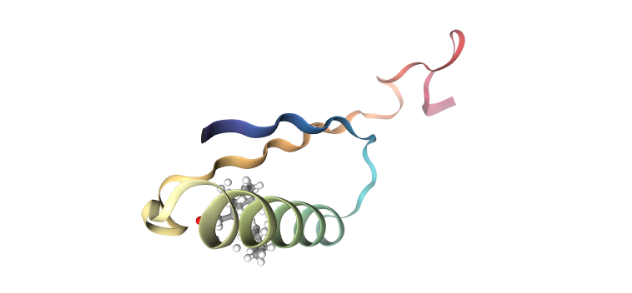


In [ ]:
v = nglview.show_rdkit(complex_mol_array[1])
display(v)

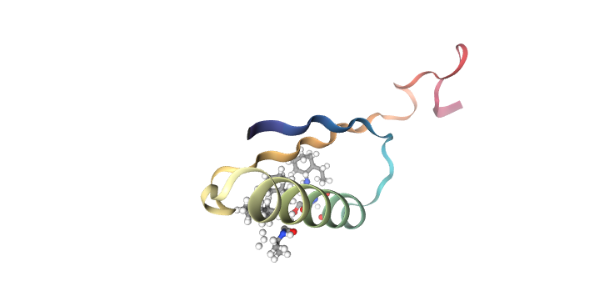

In [ ]:
v = nglview.show_rdkit(complex_mol_array[2])
display(v)

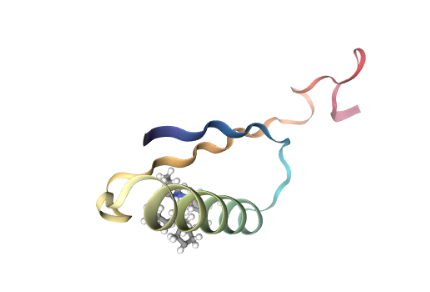

In [ ]:
print(scores_matrix)

In [ ]:
from google.colab import drive
import os
import shutil
import time

# Function to ensure directory creation with retries
def ensure_dir(directory):
    attempt = 0
    max_attempts = 5
    while attempt < max_attempts:
        try:
            os.makedirs(directory, exist_ok=True)
            if os.path.exists(directory):
                print(f"Directory verified: {directory}")
                return True
        except Exception as e:
            print(f"Error creating directory {directory}: {e}")
            print(f"Attempt {attempt + 1} failed, retrying in 5 seconds...")
            time.sleep(5)
            attempt += 1
    return False

# Mount Google Drive and define the base directory
drive.mount('/content/drive', force_remount=True)
base_dir = '/content/drive/My Drive/drug_discovery_datasets'

# Ensure the output directory is ready
output_dir = os.path.join(base_dir, 'output')
if not ensure_dir(output_dir):
    raise Exception("Failed to prepare the output directory after several attempts.")

# Assuming `jobname` and `run_relax` are defined earlier in your notebook
pred_output_path = os.path.join(output_dir, f'{jobname}_selected_prediction.pdb')
zip_output_path = os.path.join(output_dir, f'{jobname}_prediction.zip')

# Save the prediction
with open(pred_output_path, 'w') as f:
    f.write(relaxed_pdb)
    print(f'Saved prediction to {pred_output_path}')

# Create a zip-archive of the prediction
shutil.make_archive(base_name=zip_output_path.rstrip('.zip'), format='zip', root_dir=output_dir)
print(f'Prediction zip archive created at {zip_output_path}')

# Upload to Google Drive if required
if save_to_google_drive:
    from pydrive.drive import GoogleDrive
    from pydrive.auth import GoogleAuth
    from oauth2client.client import GoogleCredentials

    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
    uploaded.SetContentFile(zip_output_path)
    uploaded.Upload()
    print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

# Optional: Download the zip file to local machine
from google.colab import files
files.download(zip_output_path)





Next, we can see that all the scores generated from Vina Pose Generator for the respective complexes are negative. This is because protein–ligand binding occurs only when the change in Gibbs free energy (ΔG) of the system is negative and more negative the free energy is the more stable the complex would be as show in [Ref.]( https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4783878/) Additionally, molecular docking evaluation based on the paper [here](https://dergipark.org.tr/tr/download/article-file/647929#:~:text=The%20molecular%20docking%20evaluation%20showed,%2D18.5%20kcal%2Fmol) showed that the binding affinities of all the derivatives range from (- 3.2 and -18.5 kcal/mol).

Hence based on our experiment we can successfully predict the potential affinity between a protein sequence and a ligand even of we just have the protein sequence!


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

### Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)

This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.


```
@manual{DeepChemXAlphafold,
 title={Applications of DeepChem with Alphafold: Docking and protein-ligand interaction from protein sequence},
 organization={DeepChem},
 author={Bellamkonda, Sriphani Vardhan},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/DeepChemXAlphafold.ipynb}},
 year={2023},
}
```